# Analysis for the experiments on the SINC scenario

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from itertools import combinations

In [2]:
# Settings
fileName = "resultsSINC.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [3]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering', ''], header=0, index_col=False)
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [4]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]
# Remove rows with strength 2
dfFiltered = dfFiltered[dfFiltered['Strength'] != 2]

In [5]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['Generator']).agg({'TSTime':'count'}))

              TSTime
Generator           
ACTS               7
ACTS w SEEDS       7
PICT              11
PICT w SEEDS      11
pMEDICI            9
pMEDICI+           9


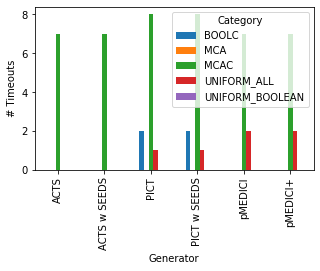

In [6]:
timeouts = dfFiltered[dfFiltered['TSTime'] == -1].groupby(['Generator', 'ModelName']).agg({'TSTime':'count'}).reset_index()
categories = ['BOOLC', 'MCA', 'MCAC', 'UNIFORM_ALL', 'UNIFORM_BOOLEAN']
generator = timeouts['Generator'].unique()
# Define, starting from timeouts and categories, a new dataframe having three colunns: Generator, Category (matching the ModelName with the category), and Count
dfTimeouts = pd.DataFrame(columns=['Generator', 'Category', 'Count'])
for g in generator:
    for c in categories:
        count = 0
        for index, row in timeouts.iterrows():
            if row['Generator'] == g and (c + "_") in row['ModelName']:
                count = count + 1
        dfTimeouts.loc[len(dfTimeouts)] = [g, c, count]

# Plot dfTimeouts in a single Histogram having on the x-axis the generator and on the y-axis the number of timeouts, and using a serie for each category
fig, ax = plt.subplots()
dfTimeouts.pivot(index='Generator', columns='Category', values='Count').plot(kind='bar', stacked=False, ax=ax)
ax.set_ylabel('# Timeouts')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(5, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_Timeouts.pdf", bbox_inches='tight')

In [7]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 301000

In [8]:

# Print the average time and size for each Generator
# print(dfFiltered.groupby(['Generator']).agg({'TSSize':'mean', 'TSTime':'mean'}))
print(dfFiltered.groupby(['Generator']).agg({'TSTime':'mean'}))
print(dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])].groupby(['Generator']).agg({'TSSize':'mean'}))

                 TSTime
Generator              
ACTS          46339.140
ACTS w SEEDS  46342.580
PICT          71433.744
PICT w SEEDS  70915.136
pMEDICI       64956.988
pMEDICI+      62856.200
                   TSSize
Generator                
ACTS           864.473684
ACTS w SEEDS   864.473684
PICT           913.868421
PICT w SEEDS   934.715789
pMEDICI       1147.073684
pMEDICI+      1130.068421


## Time analysis

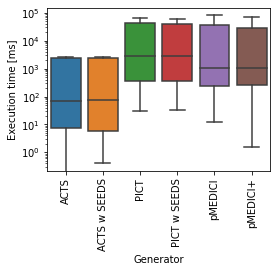

In [9]:
# Extract the execution time of different generators
dfExecutionTime = dfFiltered[['Generator','TSTime']]

# Boxplot the execution time of different generators and remove the outliers
ax = sns.boxplot(x='Generator', y='TSTime', data=dfExecutionTime, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax = dfExecutionTime.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Execution time [ms]')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Time.pdf", bbox_inches='tight')

In [10]:
def plotByCategory(dfFiltered, measure):
    dfFiltered2 = dfFiltered
    dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCAC_"), 'ModelName'] = "MCAC"
    dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("BOOLC_"), 'ModelName'] = "BOOLC"
    dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCA_"), 'ModelName'] = "MCA"
    dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_ALL_"), 'ModelName'] = "UNIFORM_ALL"
    dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_BOOLEAN_"), 'ModelName'] = "UNIFORM_BOOLEAN"
        
    # Extract the execution time of different generators
    if (measure == 'Time'):
        dfExecution = dfFiltered2[['Generator','TSTime','ModelName']]
        yLabel = 'Execution time [ms]'
        yValue = 'TSTime'
    else:
        dfExecution = dfFiltered2[['Generator','TSSize','ModelName']]
        yLabel = 'Test Suite Size'        
        yValue = 'TSSize'

    # Boxplot the execution time of different generators and remove the outliers
    ax = sns.boxplot(x="ModelName", y=yValue,
            hue="Generator",
            data=dfExecution, showfliers=False)
    ax.legend(loc='best', ncol=2, title='Generator')
    ax.set_yscale('log')
    ax.set_ylabel(yLabel)
    ax.set_xlabel('Category')
    ax.set_title('')
    plt.suptitle('')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
    # Export the figure in PDF
    plt.savefig("pictures/SINC_TS_" + measure + "_Categories.pdf", bbox_inches='tight')

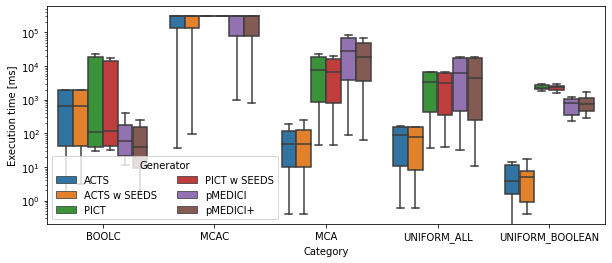

In [11]:
plotByCategory(dfFiltered, 'Time')

In [12]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS ACTS w SEEDS:
 WilcoxonResult(statistic=298.5, pvalue=0.20163831287732137)
ACTS VS PICT:
 WilcoxonResult(statistic=63.0, pvalue=7.393543157885902e-07)
ACTS VS PICT w SEEDS:
 WilcoxonResult(statistic=64.0, pvalue=7.86630203451396e-07)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=213.0, pvalue=0.0016924355869518477)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=224.0, pvalue=0.0026413226835434577)
ACTS w SEEDS VS PICT:
 WilcoxonResult(statistic=64.0, pvalue=7.86630203451396e-07)
ACTS w SEEDS VS PICT w SEEDS:
 WilcoxonResult(statistic=65.0, pvalue=8.368110643591623e-07)
ACTS w SEEDS VS pMEDICI:
 WilcoxonResult(statistic=213.0, pvalue=0.0016924355869518477)
ACTS w SEEDS VS pMEDICI+:
 WilcoxonResult(statistic=226.0, pvalue=0.0028589227279413832)
PICT VS PICT w SEEDS:
 WilcoxonResult(statistic=185.0, pvalue=0.004225610185884696)
PICT VS pMEDICI:
 WilcoxonResult(statistic=432.0, pvalue=0.8073691126849867)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=430.0, pvalue=0.7880614528059118)
PICT w

/Users/andrea/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Size analysis

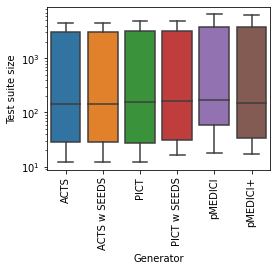

In [13]:
# Extract the TS Size of different generators
dfTSSize = dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])][['Generator','TSSize']]

# Boxplot the TS Size of different generators and remove the outliers
ax = sns.boxplot(x='Generator', y='TSSize', data=dfTSSize, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax = dfTSSize.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Test suite size')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Size.pdf", bbox_inches='tight')

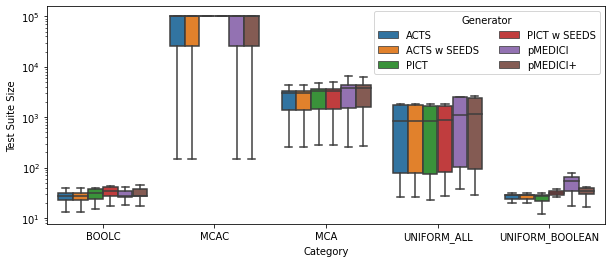

In [14]:
plotByCategory(dfFiltered, 'Size')

In [15]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfTSSize['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    if not (generator1 in ['ACTS', 'ACTS W SEEDS'] and generator2 in ['ACTS', 'ACTS W SEEDS']):
        print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfTSSize[dfTSSize['Generator'] == generator1]['TSSize'], dfTSSize[dfTSSize['Generator'] == generator2]['TSSize'], zero_method='zsplit'))

ACTS VS ACTS w SEEDS:
 WilcoxonResult(statistic=105.0, pvalue=1.0)
ACTS VS PICT:
 WilcoxonResult(statistic=51.5, pvalue=0.04526460402989079)
ACTS VS PICT w SEEDS:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
ACTS w SEEDS VS PICT:
 WilcoxonResult(statistic=51.5, pvalue=0.04526460402989079)
ACTS w SEEDS VS PICT w SEEDS:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
ACTS w SEEDS VS pMEDICI:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
ACTS w SEEDS VS pMEDICI+:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
PICT VS PICT w SEEDS:
 WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
PICT VS pMEDICI:
 WilcoxonResult(statistic=5.0, pvalue=1.9073486328125e-05)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=11.0, pvalue=0.0001049041748046875)
PICT w SEEDS VS pMEDICI:
 WilcoxonResult(statist

/Users/andrea/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
